In [1]:
from google.colab import drive
drive.mount('/content/drive')
RESEARCH_WORK_PATH = "/content/drive/My Drive/Colab Notebooks/BachelorResearch/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import math
import torch
from torch import nn

# Model

In [3]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [4]:
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [5]:
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [6]:
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [7]:
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [8]:
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [9]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [10]:
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Model (Instance)

In [11]:
from torch import optim

num_1d_features = 26
model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=num_1d_features).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

In [12]:
import soundfile as sf
import librosa
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras 
import os
import cv2
import pickle
import torch

model_path = '/content/drive/MyDrive/Colab Notebooks/BachelorResearch/models/multimodal_5s_0.5shift.pth'
model.load_state_dict(torch.load(model_path))
scaler = pickle.load(open(RESEARCH_WORK_PATH + "/models/1d_scaler_5s_0.5shift.pickle", "rb"))
model.eval()

MultiModalNet(
  (features2d): Sequential(
    (0): ConvBN(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Swish()
    (2): BMConvBlock(
      (layers): Sequential(
        (0): ConvBN(
          (layers): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Swish()
        (2): SEblock(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): Swish()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (3): ConvBN(
          (layers): Sequential(
            (0): Conv2d(32, 16, k

# Prediction

In [13]:
from typing import Sequence
def min_max(x, axis=None): # do min_max normalization ?->https://atmarkit.itmedia.co.jp/ait/articles/2110/07/news027.html
    min = 0
    max = 159.42822
    # max = 137.74599
    x = np.abs(x)
    result = (x-min)/(max-min)
    return result

def quality_prediction(audio_path): # return prediction value
  data, sr = librosa.load(audio_path) 
  broken_flag = False

  sum = torch.zeros(4, device='cuda')
  for i in range(46):
    start = sr//2*i
    stop  = 5*sr + sr//2*i

    # STFT
    n_fft=512
    hop_length=256
    
    y = data[start:stop]

    x = []
    try:
      stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    except ValueError :
      # print("[PASS] No data in", audio_path)
      broken_flag = True
      continue

    # Normalization
    stft = min_max(stft)

    # Data Transform
    stft = np.expand_dims(stft, axis=2)
    stft = np.expand_dims(stft, axis=0) # (Batch, Height, Width, Color)
    stft = torch.from_numpy(stft.astype(np.float32)).clone()
    stft = stft.permute(0,3,2,1)
    stft = stft.to('cuda')

    

    # np.set_printoptions(suppress=True)
    # print(input.shape)
    # print(type(input))
    # print(input[0,:,:,0])
    # print(input[0,:,:,1])
    # print(input[0,:,:,2])
    try: 
      chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
      rmse = librosa.feature.rms(y=y) # librosaのバージョンが0.7.0以上の場合はこちらを実行
      spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
      spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
      rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
      zcr = librosa.feature.zero_crossing_rate(y)
      mfcc = librosa.feature.mfcc(y=y, sr=sr)
      r = [np.mean(chroma_stft), np.mean(rmse), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
      for e in mfcc:
        r.append(np.mean(e))
    except ValueError:
      # print("[PASS] No data in", audio_path)
      broken_flag = True
      continue

    r = np.array(r, dtype=float)
    r = np.expand_dims(r,0)
    r = scaler.transform(r)
    r = torch.from_numpy(r).float()
    r = r.to('cuda')
    
    x.append(r)
    x.append(stft)


    # Predict
    try:
      scores = model(x)
    except ValueError:
      # print("[PASS] Not enough:", audio_path)
      scores = np.zeros(4)
      broken_flag = True
      continue

    # print(scores)

    # Get sum
    sum = sum + scores
  if broken_flag:
    print(pathlib.Path(audio_path).stem, "seems broken. len:", round(len(data)/sr,4) ,"sec")
  return sum




def path_to_audiofiles(dir_folder):
    list_of_audio = []
    for file in os.listdir(dir_folder):
        if file.endswith(".wav"):
            directory = "%s%s" % (dir_folder, file)
            list_of_audio.append(directory)
    return list_of_audio

RESEARCH_WORK_PATH = "/content/drive/My Drive/Colab Notebooks/BachelorResearch/"
unknown = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/renamed/unknown/"


In [14]:
# from tqdm import tqdm

data = np.zeros((4,4))

for audio in (path_to_audiofiles(unknown)):
  y = int(pathlib.Path(audio).stem[1])-1
  print("True: Q" +  str(y+1))
  p = int(torch.argmax(quality_prediction(audio), 1))
  print("Pred: Q" +  str(p+1))
  data[y][p] += 1

True: Q1
Pred: Q1
True: Q1


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1763
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=0
  n_fft, y.shape[-1]


Q1.MT0013914319 seems broken. len: 10.08 sec
Pred: Q3
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q2
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q4
True: Q1
Pred: Q4
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q1
Pred: Q2
True: Q1
Pred: Q2
True: Q1
Pred: Q1
True: Q1
Pred: Q3
True: Q1
Pred: Q4
True: Q1
Pred: Q1
True: Q1
Pred: Q3
True: Q1
Pred: Q1
True: Q1


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1763
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=0
  n_fft, y.shape[-1]


Q1.MT0013621344 seems broken. len: 10.08 sec
Pred: Q4
True: Q1
Pred: Q1
True: Q1
Pred: Q1
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q1
True: Q2
Pred: Q2
True: Q2
Pred: Q4
True: Q2
Pred: Q2
True: Q2
Pred: Q1
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q4
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q1
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q2
Pred: Q1
True: Q3
Pred: Q4
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q2
Pred: Q2
True: Q2
Pred: Q2
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q4
True: Q2
Pred: Q2
True: Q3
Pred: Q3
True: Q3
Pred: Q4
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q2
True: Q3
Pred: Q4
True: Q3
Pred: Q3
True: Q3
Pred: Q1
True: Q4
Pred: Q4
True: Q3
Pred: Q3
True: Q3
Pred: Q4
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q3
Pred: Q3
True: Q4
Pred: Q1
True: Q4
P

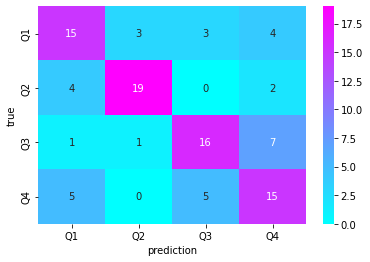

[[15.  3.  3.  4.]
 [ 4. 19.  0.  2.]
 [ 1.  1. 16.  7.]
 [ 5.  0.  5. 15.]]
[[60. 12. 12. 16.]
 [16. 76.  0.  8.]
 [ 4.  4. 64. 28.]
 [20.  0. 20. 60.]]


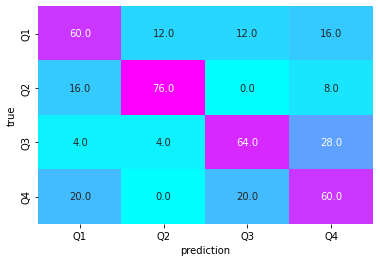

In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

combined_arr = data
xl = ["Q1", "Q2", "Q3", "Q4"]
yl = xl


sns.heatmap(combined_arr, annot=True, fmt=".0f", xticklabels=xl, yticklabels=yl, cmap="cool")
plt.ylabel("true")
plt.xlabel("prediction")
plt.show()
print(combined_arr)
print(np.array(combined_arr)/combined_arr.sum(axis=1)*100)
sns.heatmap(np.array(combined_arr)/combined_arr.sum(axis=1)*100, annot=True, fmt=".1f", xticklabels=xl, yticklabels=yl, cmap="cool", cbar=False)
plt.ylabel("true")
plt.xlabel("prediction")
plt.show()

# 200 epoch

[[14.  3.  3.  5.]
 [ 6. 16.  0.  3.]
 [ 3.  0. 17.  5.]
 [ 1.  0.  8. 16.]]


[[56. 12. 12. 20.]
 [24. 64.  0. 12.]
 [12.  0. 68. 20.]
 [ 4.  0. 32. 64.]]

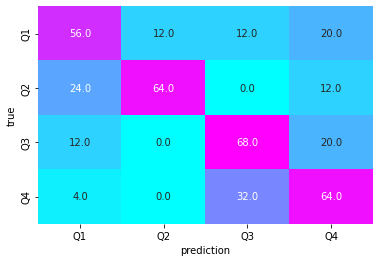

# 40 epoch
[[21.  0.  1.  3.]
 [21.  2.  0.  2.]
 [ 5.  0. 16.  4.]
 [ 2.  0. 10. 13.]]


[[84.  0.  4. 12.]
 [84.  8.  0.  8.]
 [20.  0. 64. 16.]
 [ 8.  0. 40. 52.]]

 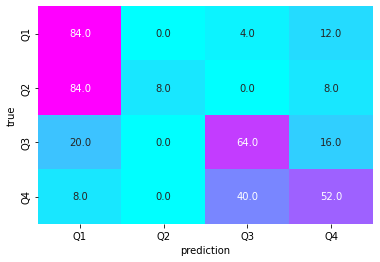
